SEE Rate: 10.000000000000002 events/s
SEE Cross Section: 1e-09 cm²


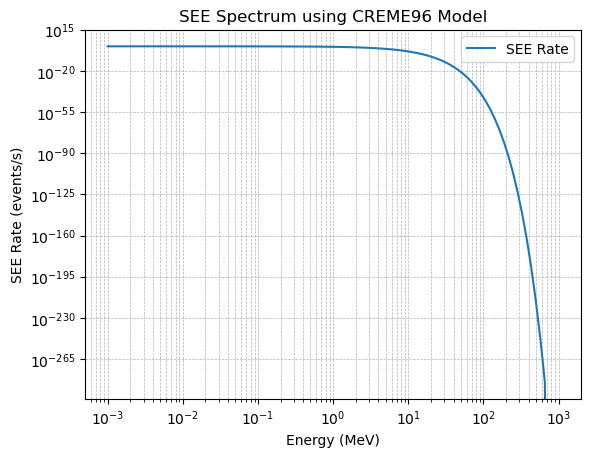

In [1]:
import numpy as np
from scipy.stats import poisson
from scipy.integrate import quad
import matplotlib.pyplot as plt

class CREME96Model:
    def __init__(self, let_rate, junction_area, particle_energy, particle_flux):
        self.let_rate = let_rate          # LET in MeV/(cm²)
        self.junction_area = junction_area  # Junction area in cm²
        self.particle_energy = particle_energy  # Energy of particles in MeV
        self.particle_flux = particle_flux  # Flux in particles/cm²/s

    def calculate_see_rate(self):
        # Simplistic approximation: rate = flux × LET × area
        return self.particle_flux * self.let_rate * self.junction_area

    def simulate_see(self, num_particles):
        # Generate random SEE events based on Poisson distribution
        mean_rate = self.calculate_see_rate()
        see_events = poisson.rvs(mean_rate, size=num_particles)
        return see_events

    def calculate_see_cross_section(self):
        # Simplistic SEE cross-section approximation
        return self.let_rate * self.junction_area

    def plot_see_spectrum(self):
        # Simulate SEE spectrum for a range of energies
        energies = np.logspace(-3, 3, 100)  # Energies in MeV
        see_rates = [self.particle_flux * self.junction_area * self.let_rate * np.exp(-e / self.particle_energy) for e in energies]

        # Plot
        plt.loglog(energies, see_rates, label='SEE Rate')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('SEE Rate (events/s)')
        plt.title('SEE Spectrum using CREME96 Model')
        plt.legend()
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()

# Example usage:
creme96_model = CREME96Model(let_rate=1e-5, junction_area=1e-4, particle_energy=1, particle_flux=1e10)
see_rate = creme96_model.calculate_see_rate()
see_events = creme96_model.simulate_see(1000)
see_cross_section = creme96_model.calculate_see_cross_section()

print(f"SEE Rate: {see_rate} events/s")
print(f"SEE Cross Section: {see_cross_section} cm²")
creme96_model.plot_see_spectrum()


In [6]:
import numpy as np
from scipy.stats import poisson, chi2
from dataclasses import dataclass
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import math
from scipy.special import factorial

@dataclass
class SEEDataPoint:
    """Single SEE data point from testing"""
    let: float              # Linear Energy Transfer (MeV·cm²/mg)
    cross_section: float    # Cross section (cm²)
    events: int            # Number of events observed
    fluence: float         # Particle fluence (particles/cm²)

@dataclass
class WeibullParams:
    """Weibull function parameters"""
    sigma_lim: float    # Limiting cross section (cm²)
    let0: float        # Onset LET (MeV·cm²/mg)
    width: float       # Width parameter
    shape: float       # Shape parameter

def load_table_1_data() -> List[SEEDataPoint]:
    """
    Load the data from Table I in the Ladbury paper
    
    Returns:
        List of SEEDataPoint objects containing the test data
    """
    data = [
        SEEDataPoint(7.80, 0.00e0, 0, 1.00e7),
        SEEDataPoint(11.03, 0.00e0, 0, 1.00e7),
        SEEDataPoint(15.60, 0.00e0, 0, 1.00e7),
        SEEDataPoint(28.80, 1.00e-7, 1, 9.99e6),
        SEEDataPoint(40.73, 6.29e-6, 50, 7.95e6),
        SEEDataPoint(53.10, 2.79e-5, 100, 3.59e6),
        SEEDataPoint(57.60, 4.01e-5, 100, 2.50e6),
        SEEDataPoint(75.09, 1.00e-4, 100, 9.46e5),
        SEEDataPoint(106.20, 2.36e-4, 100, 4.23e5)
    ]
    return data

def calculate_weibull(let: float, params: WeibullParams) -> float:
    """
    Calculate Weibull function value for given LET and parameters
    
    Args:
        let: Linear Energy Transfer value
        params: Weibull parameters
        
    Returns:
        Cross section value from Weibull function
    """
    if let < params.let0:
        return 0.0
    
    exponent = ((let - params.let0) / params.width) ** params.shape
    return params.sigma_lim * (1 - np.exp(-exponent))

def safe_factorial(n: int) -> float:
    """
    Safely calculate factorial for integers
    Uses Stirling's approximation for large n
    """
    if n > 100:
        # Stirling's approximation
        return math.sqrt(2 * math.pi * n) * (n / math.e) ** n
    return math.factorial(n)

def calculate_log_likelihood(data: List[SEEDataPoint], params: WeibullParams) -> float:
    """
    Calculate total log likelihood for dataset given Weibull parameters
    
    Args:
        data: List of SEE data points
        params: Weibull parameters to evaluate
        
    Returns:
        Log likelihood value
    """
    total_ll = 0.0
    
    for point in data:
        cross_section = calculate_weibull(point.let, params)
        mu = point.fluence * cross_section
        
        if mu <= 0:
            if point.events > 0:
                return -np.inf
            continue
            
        # For zero events, just add -mu term
        if point.events == 0:
            total_ll += -mu
        else:
            # For non-zero events, use full Poisson formula
            total_ll += (point.events * math.log(mu) - mu - 
                        math.log(safe_factorial(point.events)))
                
    return total_ll

def calculate_likelihood_ratio(data: List[SEEDataPoint], 
                             test_params: WeibullParams,
                             best_fit_params: WeibullParams) -> float:
    """
    Calculate likelihood ratio between test parameters and best fit
    
    Args:
        data: List of SEE data points
        test_params: Parameters to test
        best_fit_params: Best fit parameters
        
    Returns:
        Log of likelihood ratio
    """
    ll_test = calculate_log_likelihood(data, test_params)
    ll_best = calculate_log_likelihood(data, best_fit_params)
    return ll_test - ll_best

def calculate_confidence_threshold(confidence_level: float = 0.95, 
                                num_params: int = 4) -> float:
    """
    Calculate threshold for confidence contour
    
    Args:
        confidence_level: Desired confidence level (default 0.95)
        num_params: Number of parameters in model (default 4)
        
    Returns:
        Likelihood ratio threshold for confidence contour
    """
    chi2_val = chi2.ppf(confidence_level, df=num_params)
    return -0.5 * chi2_val

def calculate_let025(params: WeibullParams) -> float:
    """
    Calculate LET_0.25 (LET where Weibull reaches 25% of saturation)
    
    Args:
        params: Weibull parameters
        
    Returns:
        LET_0.25 value
    """
    return params.let0 + params.width * (0.288) ** (1/params.shape)

def print_parameter_analysis(data: List[SEEDataPoint], params: WeibullParams):
    """Print detailed analysis of parameters and likelihood"""
    ll = calculate_log_likelihood(data, params)
    let025 = calculate_let025(params)
    
    print("\nParameter Analysis:")
    print(f"{'Parameter':<15} {'Value':<15} {'Units'}")
    print("-" * 45)
    print(f"{'σ_lim':<15} {params.sigma_lim:.2e} {'cm²':<15}")
    print(f"{'LET_0':<15} {params.let0:.2f} {'MeV·cm²/mg':<15}")
    print(f"{'Width':<15} {params.width:.2f} {'MeV·cm²/mg':<15}")
    print(f"{'Shape':<15} {params.shape:.2f} {'':<15}")
    print(f"{'LET_0.25':<15} {let025:.2f} {'MeV·cm²/mg':<15}")
    print(f"\nLog Likelihood: {ll:.2f}")

def main():
    """Main function to demonstrate the analysis steps"""
    # 1. Load the data
    print("Loading Table I data...")
    data = load_table_1_data()
    
    # 2. Define best fit parameters from paper
    print("\nUsing best fit parameters from paper...")
    best_fit = WeibullParams(
        sigma_lim=3.13e-4,
        let0=26.0,
        width=70.0,
        shape=2.5
    )
    
    # 3. Analyze best fit parameters
    print_parameter_analysis(data, best_fit)
    
    # 4. Calculate 95% confidence threshold
    conf_threshold = calculate_confidence_threshold()
    print(f"\n95% confidence threshold: {conf_threshold:.2f}")
    
    # 5. Example: Test a different parameter set
    print("\nTesting alternative parameters...")
    test_params = WeibullParams(
        sigma_lim=3.13e-4,
        let0=26.0,
        width=75.0,  # Changed from best fit
        shape=2.7    # Changed from best fit
    )
    
    ll_ratio = calculate_likelihood_ratio(data, test_params, best_fit)
    print(f"Log likelihood ratio for test parameters: {ll_ratio:.2f}")
    print(f"Within 95% confidence? {ll_ratio > conf_threshold}")

if __name__ == "__main__":
    main()

Loading Table I data...

Using best fit parameters from paper...

Parameter Analysis:
Parameter       Value           Units
---------------------------------------------
σ_lim           3.13e-04 cm²            
LET_0           26.00 MeV·cm²/mg     
Width           70.00 MeV·cm²/mg     
Shape           2.50                
LET_0.25        68.55 MeV·cm²/mg     

Log Likelihood: -16.77

95% confidence threshold: -4.74

Testing alternative parameters...
Log likelihood ratio for test parameters: -18.43
Within 95% confidence? False


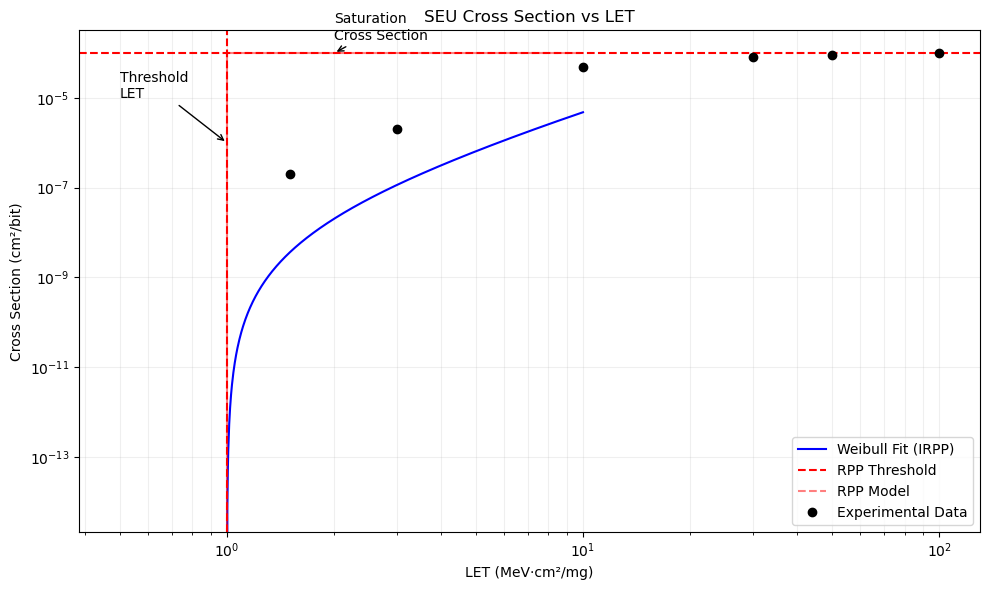

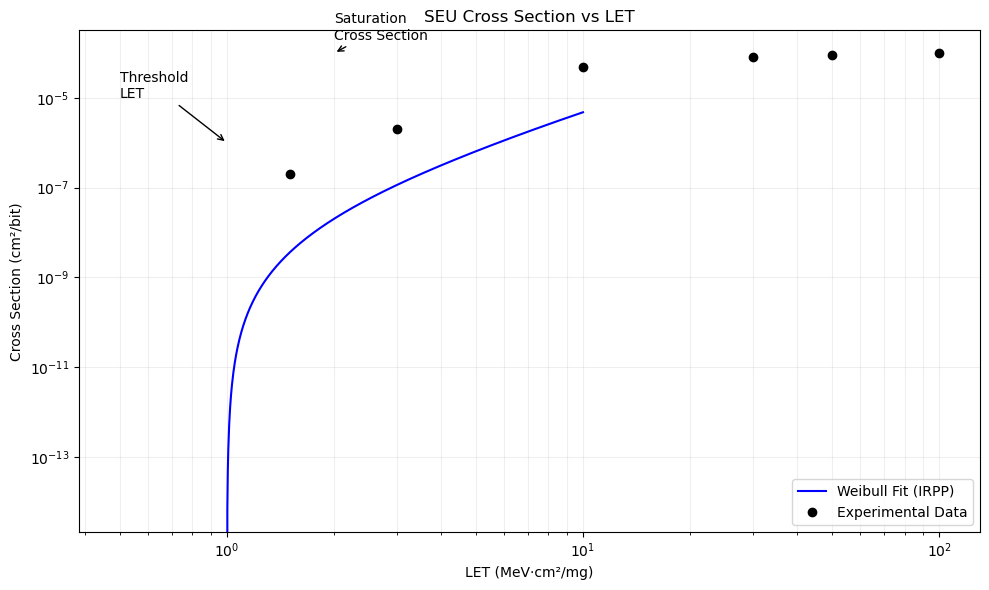

In [8]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.optimize import curve_fit

@dataclass
class CrossSectionData:
    """Cross section curve parameters"""
    let_threshold: float    # LET threshold (MeV·cm²/mg)
    sigma_sat: float       # Saturation cross-section (cm²)
    width: float          # Width parameter for Weibull
    shape: float          # Shape parameter for Weibull

def weibull_curve(let: float, let_th: float, sigma_sat: float, width: float, shape: float) -> float:
    """
    Calculate Weibull curve point
    
    Args:
        let: Linear Energy Transfer value
        let_th: LET threshold
        sigma_sat: Saturation cross-section
        width: Width parameter
        shape: Shape parameter
    """
    if let < let_th:
        return 0.0
    return sigma_sat * (1 - np.exp(-((let - let_th)/width)**shape))

def plot_cross_sections(data: CrossSectionData, 
                       experimental_points: List[Tuple[float, float]] = None,
                       show_rpp: bool = True):
    """
    Plot cross-section vs LET curves
    
    Args:
        data: CrossSectionData containing Weibull parameters
        experimental_points: Optional list of (LET, cross-section) measurements
        show_rpp: Whether to show RPP step function
    """
    plt.figure(figsize=(10, 6))
    
    # Create LET range for plotting
    let_range = np.logspace(
        np.log10(max(0.1, data.let_threshold/2)), 
        np.log10(data.let_threshold*10), 
        1000
    )
    
    # Calculate Weibull curve
    cross_sections = [weibull_curve(let, data.let_threshold, 
                                  data.sigma_sat, data.width, 
                                  data.shape) for let in let_range]
    
    # Plot Weibull curve
    plt.loglog(let_range, cross_sections, 'b-', label='Weibull Fit (IRPP)')
    
    # Plot RPP step function if requested
    if show_rpp:
        plt.axvline(x=data.let_threshold, color='r', linestyle='--', label='RPP Threshold')
        plt.axhline(y=data.sigma_sat, color='r', linestyle='--')
        
        # Add RPP step function
        rpp_lets = np.concatenate([
            let_range[let_range < data.let_threshold],
            [data.let_threshold, data.let_threshold],
            let_range[let_range > data.let_threshold]
        ])
        rpp_cross = np.concatenate([
            np.zeros(len(let_range[let_range < data.let_threshold])),
            [0, data.sigma_sat],
            np.full(len(let_range[let_range > data.let_threshold]), data.sigma_sat)
        ])
        plt.loglog(rpp_lets, rpp_cross, 'r--', alpha=0.5, label='RPP Model')
    
    # Plot experimental points if provided
    if experimental_points:
        lets, cross_secs = zip(*experimental_points)
        plt.loglog(lets, cross_secs, 'ko', label='Experimental Data')
    
    # Formatting
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel('LET (MeV·cm²/mg)')
    plt.ylabel('Cross Section (cm²/bit)')
    plt.title('SEU Cross Section vs LET')
    plt.legend()
    
    # Add annotations
    plt.annotate('Threshold\nLET', 
                xy=(data.let_threshold, data.sigma_sat/100),
                xytext=(data.let_threshold/2, data.sigma_sat/10),
                arrowprops=dict(arrowstyle='->'))
    
    plt.annotate('Saturation\nCross Section', 
                xy=(data.let_threshold*2, data.sigma_sat),
                xytext=(data.let_threshold*2, data.sigma_sat*2),
                arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    plt.show()

def main():
    """Example usage"""
    # Example device parameters (similar to 93L422AM device)
    device_data = CrossSectionData(
        let_threshold=1.0,    # MeV·cm²/mg
        sigma_sat=1e-4,       # cm²
        width=30.0,
        shape=2.5
    )
    
    # Example experimental points
    experimental_data = [
        (0.8, 0),
        (1.5, 2e-7),
        (3.0, 2e-6),
        (10.0, 5e-5),
        (30.0, 8e-5),
        (50.0, 9e-5),
        (100.0, 1e-4)
    ]
    
    # Create plots
    plot_cross_sections(device_data, experimental_data)
    
    # Also show just the Weibull fit
    plot_cross_sections(device_data, experimental_data, show_rpp=False)

if __name__ == "__main__":
    main()

Upset Rate (RPP): 0.00e+00 bit^-1 * s^-1
Upset Rate (IRPP): 7.18e-02 bit^-1 * s^-1


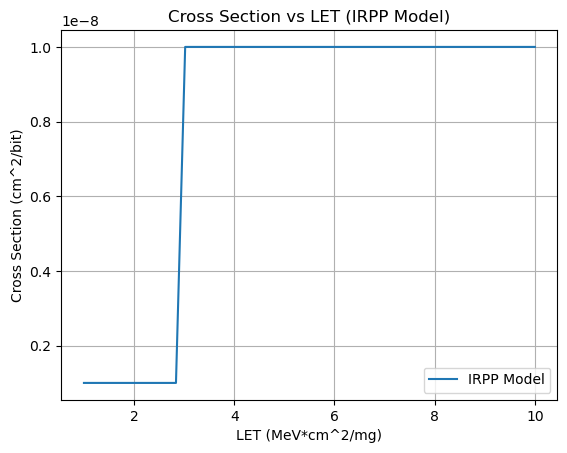

In [7]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Constants
E_CHARGE = 1.602e-19  # Elementary charge in Coulombs

# Function to calculate upset rate (RPP model)
def upset_rate_rpp(Qc, A, LET_min, LET_max, F, X_e):
    """
    Calculate the upset rate using the RPP method.
    
    Parameters:
    Qc      : Critical charge (pC)
    A       : Sensitive area (cm^2)
    LET_min : Minimum LET for an upset (MeV*cm^2/mg)
    LET_max : Maximum LET (saturation LET, MeV*cm^2/mg)
    F       : LET spectrum (particles/cm^2*s*sr)
    X_e     : Ratio of energy to create one electron-hole pair (MeV/e)
    
    Returns:
    Upset rate U in (bit^-1 * s^-1).
    """
    Qc_C = Qc * 1e-12  # Convert Qc from pC to Coulombs
    L_min = Qc_C / (X_e * E_CHARGE)  # Minimum LET needed for upset in MeV*cm^2/mg
    L_min = max(L_min, LET_min)  # Ensure LET_min is respected
    
    # RPP approximation
    if L_min > LET_max:
        return 0  # No upset if minimum LET exceeds saturation LET
    else:
        U = np.pi * A * (X_e / E_CHARGE) * Qc * F * (LET_max - L_min)
        return U

# Function to calculate upset rate (IRPP model)
def upset_rate_irpp(cross_sections, LETs, F_spectrum):
    """
    Calculate the upset rate using the IRPP method.
    
    Parameters:
    cross_sections : Array of cross sections (cm^2/bit) for corresponding LET values.
    LETs           : Array of LET values (MeV*cm^2/mg).
    F_spectrum     : LET spectrum (particles/cm^2*s*sr).
    
    Returns:
    Upset rate U in (bit^-1 * s^-1).
    """
    # Compute differential contributions to upset rate
    U = 0
    for i in range(len(LETs) - 1):
        dLET = LETs[i + 1] - LETs[i]
        sigma = cross_sections[i]
        F = F_spectrum[i]
        U += sigma * F * dLET
    return U

# Plotting function for RPP and IRPP
def plot_cross_section(LETs, cross_sections, model="IRPP"):
    """
    Plot the cross section curve.
    
    Parameters:
    LETs           : Array of LET values (MeV*cm^2/mg).
    cross_sections : Corresponding cross sections (cm^2/bit).
    model          : Model type ("RPP" or "IRPP").
    """
    plt.plot(LETs, cross_sections, label=f"{model} Model")
    plt.xlabel("LET (MeV*cm^2/mg)")
    plt.ylabel("Cross Section (cm^2/bit)")
    plt.title(f"Cross Section vs LET ({model} Model)")
    plt.grid()
    plt.legend()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Parameters for RPP
    Qc = 1.0  # Critical charge in pC
    A = 1e-4  # Sensitive area in cm^2
    LET_min = 1.0  # Minimum LET in MeV*cm^2/mg
    LET_max = 10.0  # Saturation LET in MeV*cm^2/mg
    F = 1e7  # LET spectrum (particles/cm^2*s*sr)
    X_e = 3.6  # Silicon energy to create one e-hole pair (eV)

    # Calculate upset rate using RPP
    U_rpp = upset_rate_rpp(Qc, A, LET_min, LET_max, F, X_e)
    print(f"Upset Rate (RPP): {U_rpp:.2e} bit^-1 * s^-1")

    # Parameters for IRPP
    LETs = np.linspace(1, 10, 50)  # LET range in MeV*cm^2/mg
    cross_sections = np.array([1e-8 if LET > 3 else 1e-9 for LET in LETs])  # Example Weibull fit
    F_spectrum = np.full_like(LETs, 1e6)  # Constant flux for simplicity

    # Calculate upset rate using IRPP
    U_irpp = upset_rate_irpp(cross_sections, LETs, F_spectrum)
    print(f"Upset Rate (IRPP): {U_irpp:.2e} bit^-1 * s^-1")

    # Plot cross-section
    plot_cross_section(LETs, cross_sections, model="IRPP")


SEE Rate: 8.41e+00 events/s


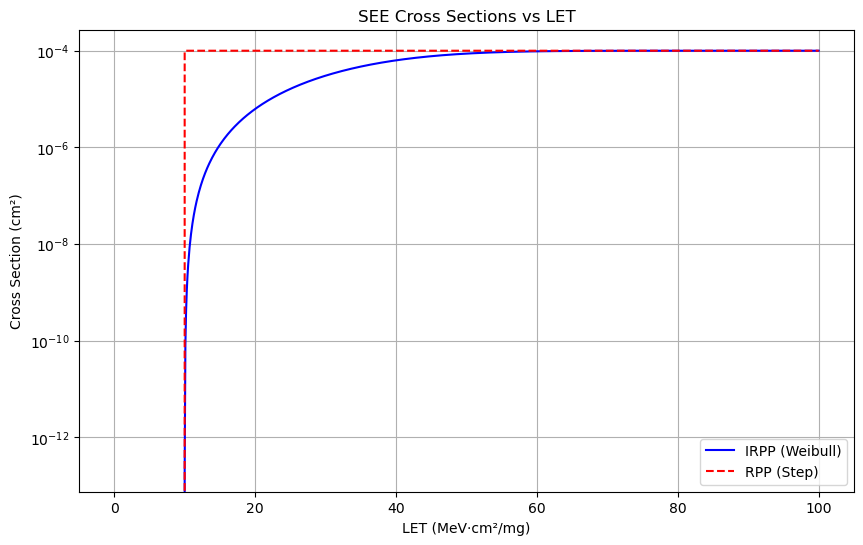

In [12]:
import numpy as np
from scipy.integrate import quad
from dataclasses import dataclass
import matplotlib.pyplot as plt

@dataclass
class DeviceParameters:
    """Device parameters for SEE calculations"""
    critical_charge: float  # Critical charge in pC
    junction_area: float   # Junction area in cm²
    let_threshold: float   # LET threshold in MeV·cm²/mg

class SEEModel:
    def __init__(self, device: DeviceParameters, flux: float):
        """
        Initialize SEE model
        
        Args:
            device: DeviceParameters object
            flux: Particle flux in particles/cm²/s
        """
        self.device = device
        self.flux = flux
        
    def weibull_cross_section(self, let: float, w: float = 30, s: float = 2.5) -> float:
        """
        Calculate cross section using Weibull function
        
        Args:
            let: Linear Energy Transfer in MeV·cm²/mg
            w: Width parameter
            s: Shape parameter
        
        Returns:
            Cross section in cm²
        """
        if let < self.device.let_threshold:
            return 0.0
        
        exponent = -((let - self.device.let_threshold) / w) ** s
        return self.device.junction_area * (1 - np.exp(exponent))
    
    def calculate_see_rate(self, let_max: float = 100.0) -> float:
        """
        Calculate SEE rate by integrating over LET spectrum
        
        Args:
            let_max: Maximum LET to consider in MeV·cm²/mg
            
        Returns:
            SEE rate in events/s
        """
        def integrand(let):
            # Simplified cosmic ray spectrum (exponential decay)
            spectrum = self.flux * np.exp(-let / 30)
            cross_section = self.weibull_cross_section(let)
            return spectrum * cross_section
            
        rate, _ = quad(integrand, self.device.let_threshold, let_max)
        return rate
    
    def plot_cross_sections(self, let_max: float = 100.0):
        """Plot RPP and IRPP cross sections vs LET"""
        let_values = np.linspace(0, let_max, 1000)
        
        # Calculate cross sections
        weibull_cs = [self.weibull_cross_section(let) for let in let_values]
        rpp_cs = [self.device.junction_area if let >= self.device.let_threshold else 0 
                 for let in let_values]
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(let_values, weibull_cs, 'b-', label='IRPP (Weibull)')
        plt.semilogy(let_values, rpp_cs, 'r--', label='RPP (Step)')
        plt.grid(True)
        plt.xlabel('LET (MeV·cm²/mg)')
        plt.ylabel('Cross Section (cm²)')
        plt.title('SEE Cross Sections vs LET')
        plt.legend()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Define device parameters
    device = DeviceParameters(
        critical_charge=0.1,    # pC
        junction_area=1e-4,     # cm²
        let_threshold=10       # MeV·cm²/mg
    )
    
    # Create model with particle flux
    model = SEEModel(device, flux=1e4)  # particles/cm²/s
    
    # Calculate SEE rate
    rate = model.calculate_see_rate()
    print(f"SEE Rate: {rate:.2e} events/s")
    
    # Plot cross sections
    model.plot_cross_sections()